In [16]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, l2norm
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.ksd.kernel import l2norm

from src.sensors import Sensor, SensorImproper

MCMCKernel = RandomWalkMH # RandomWalkBarker 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import autograd.numpy as np
import kgof
import kgof.density as kgof_density
import kgof.goftest as kgof_gof
import src.ksd.models_np as models_np

In [18]:
# Assume two dimensions.
d = 2
dim = d

In [19]:
# def isogauss_log_den(X):
#     """
#     Evaluate the log density at the points (rows) in X 
#     of the standard isotropic Gaussian.
#     Note that the density is NOT normalized. 
    
#     X: n x d nd-array
#     return a length-n array
#     """
#     mean = np.zeros(d)
#     variance = 1
#     unden = -np.sum((X-mean)**2, 1)/(2.0*variance)
#     return unden

delta = 6.
ratio_target = 0.5
def isogauss_log_den(X, delta=delta, ratio=ratio_target):
    """
    Bimodal Gaussian
    """
    log_ratio1 = tf.math.log(ratio)
    log_ratio2 = tf.math.log(1-ratio)
    
    mean1 = np.zeros(d)
    mean2 = np.eye(d)[:1] * delta
    variance = 1
    exp1 = -0.5 * np.sum((X-mean1)**2, axis=-1) / variance + log_ratio1
    exp2 = -0.5 * np.sum((X-mean2)**2, axis=-1) / variance + log_ratio2
    unden = np.logaddexp(exp1, exp2) # n

    return unden


## t-banana

In [173]:
## t-banana
rdg = tf.random.Generator.from_seed(1)

nbanana = 1
nmodes = 1

b = 0.003 # 0.03
t_std = 0.1
ratio_target = [1/nmodes] * nmodes
loc = rdg.uniform((nmodes, dim), minval=-tf.ones((dim,))*2, maxval=tf.ones((dim,))*2)

target, log_prob_fn = models.create_mixture_t_banana(dim=dim, ratio=ratio_target, loc=loc, b=b,
    nbanana=nbanana, std=t_std, return_logprob=True)


In [174]:
#############################################
# check if log_prob is implemented correctly
#############################################

# log_prob_fn_np = models_np.create_mixture_t_banana(dim=dim, ratio=ratio_target, loc=loc, nbanana=nbanana, 
#                         std=t_std, b=b)

# np.random.seed(1)
# X = np.random.randn(5, d)
# log_prob_fn(tf.constant(X, dtype=tf.float32))

# diff = log_prob_fn(tf.constant(X, dtype=tf.float32)) - log_prob_fn_np(X)
# tf.experimental.numpy.allclose(diff, diff[0])

In [178]:
#############################################
# check if log_prob for t-dist is implemented correctly
#############################################
np.random.seed(1)
X = np.random.randn(500, dim)

# t_loc = tf.zeros(dim)
t_loc = loc[0]

# scale = tf.eye(dim)
scale = tf.math.sqrt(t_std * tf.math.sqrt(float(dim)) * tf.eye(dim))

# pp_tf = log_prob_fn(tf.constant(X, dtype=tf.float32))
t_dist = tfd.MultivariateStudentTLinearOperator(
    df=7, 
    loc=t_loc, 
    scale=tf.linalg.LinearOperatorLowerTriangular(scale),
)
pp_tf = t_dist.log_prob(X)

Sigma = scale @ tf.transpose(scale)
Sigma_inv = tf.linalg.inv(Sigma)
pp_np = models_np.multivariate_t_logprob(X, loc=t_loc, Sigma_inv=Sigma_inv, df=7, dim=dim)

# compare
diff = pp_tf - pp_np
tf.experimental.numpy.allclose(diff, diff[0], atol=1e-06)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [182]:
#############################################
# check if log_prob for banana is implemented correctly
#############################################
np.random.seed(1)
X = np.random.randn(500, dim)

b_loc = loc[0]

pp_tf = target.log_prob(X)

pp_np = models_np.banana_logprob(X, loc=b_loc, scale=10, b=b, df=7, dim=dim)

# compare
diff = pp_tf - pp_np
tf.experimental.numpy.allclose(diff, diff[0])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [257]:
#############################################
# check if log_prob for t-banana mixture is implemented correctly
# This currently has a bug!
#############################################
np.random.seed(1)
X = np.random.randn(499, dim)

# tf version
rdg = tf.random.Generator.from_seed(1)

nbanana = 1
nmodes = 2

b = 0.003
t_std = 0.1
ratio_target = [1/nmodes] * nmodes
loc = rdg.uniform((nmodes, dim), minval=-tf.ones((dim,))*2, maxval=tf.ones((dim,))*2)
# loc = rdg.uniform((2, dim), minval=-tf.ones((dim,))*2, maxval=tf.ones((dim,))*2)
# loc = loc[:nmodes]
# loc = np.concatenate([loc[:nmodes], loc[:nmodes]])

target, log_prob_fn = models.create_mixture_t_banana(dim=dim, ratio=ratio_target, loc=loc, b=b,
    nbanana=nbanana, std=t_std, return_logprob=True)
pp_tf = log_prob_fn(X)

# np version
log_prob_fn_np = models_np.create_mixture_t_banana_logprob(
    dim, ratio=ratio_target, loc=np.array(loc, dtype=np.float64), nbanana=nbanana, std=t_std, b=b)
pp_np = log_prob_fn_np(X)

# compare
diff = pp_tf - pp_np
tf.experimental.numpy.allclose(diff, diff[0])

<tf.Tensor: shape=(), dtype=bool, numpy=False>

## RBM

In [115]:
scale_mat

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[10.,  0.],
       [ 0.,  1.]], dtype=float32)>

In [118]:
dh = 2
c_shift = 1.
c_off = tf.concat([tf.ones(2) * c_shift, tf.zeros(dh-2)], axis=0)

target, log_prob_fn = models.create_rbm(B_scale=6., c=0., dx=dim, dh=dh, burnin_number=2000, return_logprob=True)

In [119]:
banana_prob(xx, loc) / pp1

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([62.83185 , 62.831833], dtype=float32)>

In [119]:
log_prob_fn_np = models_np.create_rbm(B_scale=6., c=0., dx=dim, dh=dh)

In [103]:
scale_mat

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

## check np version of log_prob is implemented correctly

ModuleNotFoundError: No module named 'pytorch'

In [120]:
# check whether the density is implemented correctly
np.random.seed(1)
X = np.random.randn(1000, d)
X_tf = tf.constant(X, dtype=tf.float32)

assert np.allclose(log_prob_fn(X_tf), log_prob_fn_np(X))

## FSSN

In [107]:
pp1 / pp2

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.15915495, 0.15915497], dtype=float32)>

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.07957751, 0.07957748], dtype=float32)>

In [114]:
# p is an UnnormalizedDensity object
p = kgof_density.from_log_den(d, isogauss_log_den)


## tensorflow
# dim = 2

# ## mixure of gaussians
k = 1
# ratio_sample = 1.

target, log_prob_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_target)
# proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
#     dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_sample)

# p = kgof_density.from_log_den(dim, log_prob_fn)

In [216]:
# Let's assume that m = 1.

# If m=0, then p=q and H_0 is true.
m = 0
# m = 1

# Draw n points from q
seed = 4
np.random.seed(seed)
n = 400
X = np.random.randn(n, 2) + np.array([m, 0])

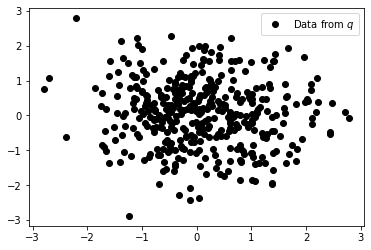

In [217]:
plt.plot(X[:, 0], X[:, 1], 'ko', label='Data from $q$')
plt.legend()

In [218]:
# dat will be fed to the test.
dat = kgof.data.Data(X)

In [219]:
# We will use 20% of the data for parameter tuning, and 80% for testing.
tr, te = dat.split_tr_te(tr_proportion=0.2, seed=2)

In [220]:
# J is the number of test locations (or features). Typically not larger than 10.
J = 1

# There are many options for the optimization. 
# Almost all of them have default values. 
# Here, we will list a few to give you a sense of what you can control.
# Full options can be found in gof.GaussFSSD.optimize_locs_widths(..)
opts = {
    'reg': 1e-2, # regularization parameter in the optimization objective
    'max_iter': 50, # maximum number of gradient ascent iterations
    'tol_fun':1e-7, # termination tolerance of the objective
}

# make sure to give tr (NOT te).
# do the optimization with the options in opts.
V_opt, gw_opt, opt_info = kgof_gof.GaussFSSD.optimize_auto_init(p, tr, J, **opts)

In [221]:
# alpha = significance level of the test
alpha = 0.05
fssd_opt = kgof_gof.GaussFSSD(p, gw_opt, V_opt, alpha)

In [222]:
# return a dictionary of testing results
test_result = fssd_opt.perform_test(te)
test_result

{'alpha': 0.05,
 'pvalue': 0.22166666666666668,
 'test_stat': 3.921161262218326e-13,
 'h0_rejected': False,
 'n_simulate': 3000,
 'time_secs': 0.0024061203002929688}

In [35]:
dim = 2

## mixure of gaussians
k = 1
delta = 8.
ratio_sample = 1.
ratio_target = 0.5

target, log_prob_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_target)
# proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
#     dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_sample)

In [36]:
log_prob_fn

<function src.ksd.models.create_mixture_gaussian_kdim.<locals>.log_prob_fn(x)>